In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

import tensorflow as tf


In [2]:
df = pd.read_csv("./Churn_Modelling.csv")
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Feature Engineering

In [3]:
def engineer_features(df, balance_threshold=100000):
    df = df.copy()

    df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)

    df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})

    geo = pd.get_dummies(df["Geography"], prefix="Geo")
    df = pd.concat([df.drop(columns=["Geography"]), geo], axis=1)

    df["credit_utilization"] = df["Balance"] / (df["CreditScore"] + 1)
    df["financial_stress"] = df["Balance"] / (df["EstimatedSalary"] + 1)
    df["engagement_score"] = (
        df["NumOfProducts"] + df["HasCrCard"] + df["IsActiveMember"]
    )
    df["high_balance_risk"] = (df["Balance"] > balance_threshold).astype(int)
    df["tenure_product_ratio"] = df["Tenure"] / (df["NumOfProducts"] + 1)
    df["salary_normalized"] = df["EstimatedSalary"] / df["EstimatedSalary"].max()
    df["age_squared"] = df["Age"] ** 2
    df["active_credit_interaction"] = df["IsActiveMember"] * df["HasCrCard"]

    feature_columns = [
        "credit_utilization", "financial_stress", "engagement_score",
        "high_balance_risk", "tenure_product_ratio", "salary_normalized",
        "age_squared", "active_credit_interaction",
        "Geo_France", "Geo_Germany", "Geo_Spain"
    ]

    X = df[feature_columns]
    y = df["Exited"]

    return X, y


X, y = engineer_features(df)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Model 1 – Support Vector Classifier (SVC)

In [28]:
from sklearn.svm import SVC

svc = SVC(
    kernel="rbf",C=0.3,gamma="scale",probability=True,random_state=28
)

svc.fit(X_train_scaled, y_train)
svc_preds = svc.predict(X_test_scaled)


SVC Metrics

In [29]:
svc_metrics = {
    "Accuracy": accuracy_score(y_test, svc_preds),
    "Precision": precision_score(y_test, svc_preds),
    "Recall": recall_score(y_test, svc_preds),
    "F1": f1_score(y_test, svc_preds),
    "ROC_AUC": roc_auc_score(y_test, svc_preds)
}

svc_metrics


{'Accuracy': 0.828,
 'Precision': 0.8118811881188119,
 'Recall': 0.20147420147420148,
 'F1': 0.3228346456692913,
 'ROC_AUC': np.float64(0.5947735100277473)}

Model 2 – ANN (Keras)

In [30]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(
        64, activation="relu",
        input_shape=(X_train_scaled.shape[1],)
    ),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = ann.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6885 - loss: 0.5687 - val_accuracy: 0.8375 - val_loss: 0.3993
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8306 - loss: 0.4072 - val_accuracy: 0.8587 - val_loss: 0.3724
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8465 - loss: 0.3803 - val_accuracy: 0.8550 - val_loss: 0.3498
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8475 - loss: 0.3660 - val_accuracy: 0.8562 - val_loss: 0.3415
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8415 - loss: 0.3682 - val_accuracy: 0.8600 - val_loss: 0.3372
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8639 - loss: 0.3413 - val_accuracy: 0.8525 - val_loss: 0.3365
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8607 - loss: 0.3438 - val_accuracy: 0.8425 - val_loss: 0.3503
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8615 - loss: 0.3389 - val_accuracy: 0.8600 - val_

In [31]:
ann_prods = ann.predict(X_test_scaled)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [32]:
ann_metrics = {
    "Accuracy": accuracy_score(y_test, ann_preds),
    "Precision": precision_score(y_test, ann_preds),
    "Recall": recall_score(y_test, ann_preds),
    "F1": f1_score(y_test, ann_preds),
    "ROC_AUC": roc_auc_score(y_test, ann_probs)
}

ann_metrics


{'Accuracy': 0.844,
 'Precision': 0.6907630522088354,
 'Recall': 0.4226044226044226,
 'F1': 0.524390243902439,
 'ROC_AUC': np.float64(0.8181108689583265)}

Metrics Comparison Table

In [36]:
comparison = pd.DataFrame([svc_metrics, ann_metrics],
                          index=["SVC", "ANN"])
comparison.T


,SVC,ANN
Accuracy,0.828000,0.844000
Precision,0.811881,0.690763
Recall,0.201474,0.422604
F1,0.322835,0.524390
ROC_AUC,0.594774,0.818111


ROC–AUC Curve Comparison

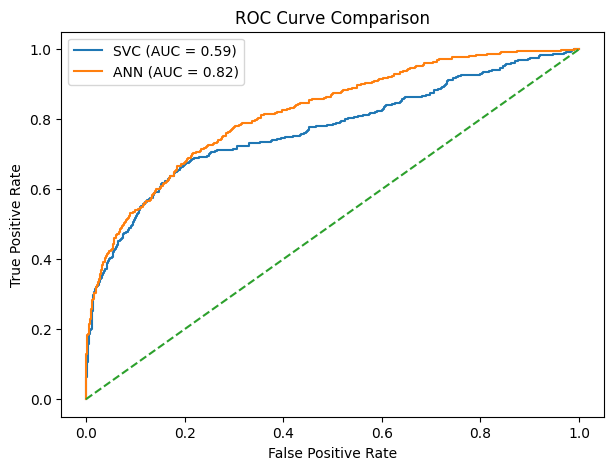

In [34]:
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)
ann_fpr, ann_tpr, _ = roc_curve(y_test, ann_probs)

plt.figure(figsize=(7,5))
plt.plot(svc_fpr, svc_tpr, label=f"SVC (AUC = {svc_metrics['ROC_AUC']:.2f})")
plt.plot(ann_fpr, ann_tpr, label=f"ANN (AUC = {ann_metrics['ROC_AUC']:.2f})")
plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


ANN Learning curve

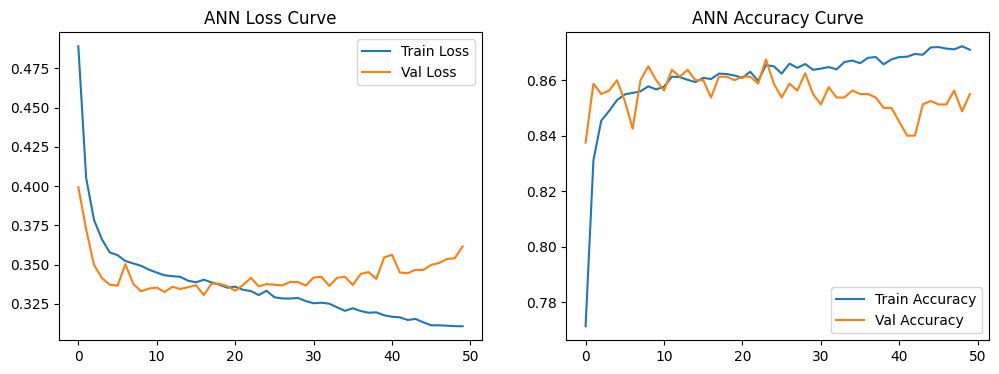

In [41]:
# ANN
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("ANN Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("ANN Accuracy Curve")
plt.legend()

plt.show()


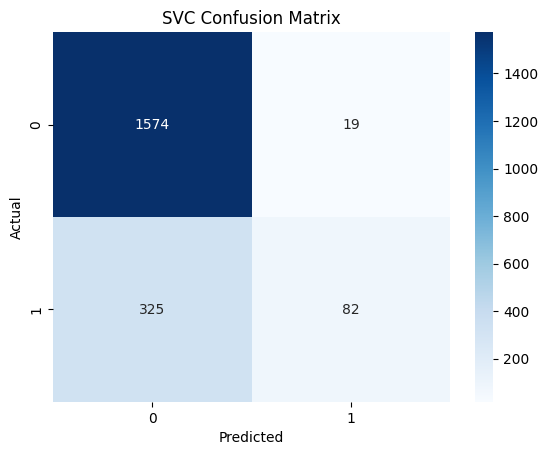

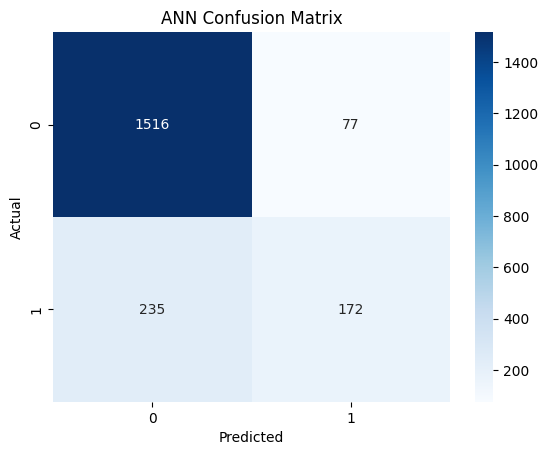

In [42]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_cm(y_test, svc_preds, "SVC Confusion Matrix")
plot_cm(y_test, ann_preds, "ANN Confusion Matrix")


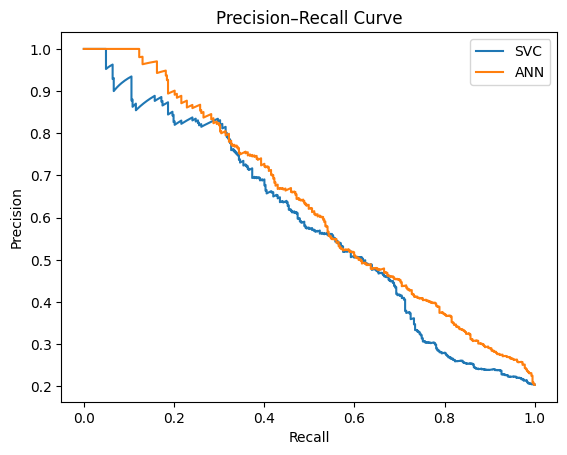

In [43]:
from sklearn.metrics import precision_recall_curve

svc_p, svc_r, _ = precision_recall_curve(y_test, svc_probs)
ann_p, ann_r, _ = precision_recall_curve(y_test, ann_probs)

plt.plot(svc_r, svc_p, label="SVC")
plt.plot(ann_r, ann_p, label="ANN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()
